In [1]:
import import_ipynb

import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline

from eunjeon import Mecab; mecab = Mecab()
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import matplotlib as mpl
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings(action='ignore')

### Function

In [2]:
def text_process(contents):
    file = open('./dataset/stopwords.txt', 'r', encoding='UTF8')
    STOPWORDS = file.read().split(', ')
    file.close()
    
    file = open('./dataset/gongju/min30.txt', 'r', encoding='utf-8')
    MINWORDS = file.read().split(',')
    file.close()
    
    content_list = [content for content in contents]
    
    content_text = ''.join(content_list)
    
    noun_list = mecab.nouns(content_text)
    
    noun_list = [x for x in noun_list if len(x)>=2]

    for i in range(len(noun_list)):
        if(noun_list[i]=='충남'):
            noun_list[i] = '충청남도'
        if(noun_list[i]=='공주'):
            noun_list[i] = '공주시'
        
    noun_list = [word for word in noun_list if word in MINWORDS]
        
    return ' '.join([word for word in noun_list if word not in STOPWORDS])

In [3]:
def getRankListFromSeries(s):
    clean_list = s.to_list()

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(clean_list)

    terms = tfidf_vectorizer.get_feature_names()

    sums = tfidf_matrix.sum(axis=0)

    data = []
    for idx, term in enumerate(terms):
           data.append( (term, sums[0, idx] ))

    ranking_df = pd.DataFrame(data, columns=['term','rank'])
    ranking_df.sort_values('rank',inplace=True, ascending=False)
    
    return tolist(ranking_df)

In [4]:
def tolist(df):
    return [tuple(r) for r in df.to_numpy()]

In [5]:
def todict(tfidf_list):
    tfidf_dict = {}
    for i in range(0,len(tfidf_list)):
        tfidf_dict[tfidf_list[i][0]] = tfidf_list[i][1]
    
    return tfidf_dict

----------------------------------------------------------------------------------------

### Load Dataset

In [6]:
data_df = pd.read_excel("./dataset/gongju/naverview_gongju.xlsx", engine="openpyxl")
data_df.head()

,title,nickname,datetime,content
0,유구한 세월의 발자취 - 공주시 유구터미널,모리노\n(goyasoul88),2008. 10. 1. 2:19,석남리\n충청남도 > 공주시 > 유구읍\n기간 2008.9.21 ~ 2008.9.2...
1,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘,오동균\n(odk1956),2006. 3. 21. 22:59,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘\n 함께하면 풍성해지는 40일 캠...
2,공주시 산림박물관 견학,하이데스\n(pygmalion999),2007. 12. 27. 15:06,산림박물관이 있는줄 얼마전에 알았다..\n어떤것이 전시되어 있는지 궁금하기도 하...
3,찬란한 백제문화를 꽃피운 공주시가와 금강줄기가 산아래 내려다 보이는,청람\n(khrnice),2006. 9. 11. 21:16,이제 완연한 가을 날씨다..\n좀처럼 한 곳에 머물기를 죽도록 싫어하는 성격이 이렇...
4,충남 기도터-충남 공주시 사곡면 벽계산 약수암 기도터,찬누리\n(jinsug9339),2007. 3. 7. 20:54,충남 공주시 사곡면 벽계산 약수암 기도터\n(위)-벽계산 약수암 기도터 주차장과 요...


### Preprocess

In [7]:
data_df['title'] = data_df['title'].astype('str')
data_df['content'] = data_df['content'].astype('str')

In [8]:
data_df['clean_title'] = data_df.title.apply(text_process)
data_df['clean_content'] = data_df['clean_title'] + " " + data_df.content.apply(text_process)

In [9]:
data_df.head()

,title,nickname,datetime,content,clean_title,clean_content
0,유구한 세월의 발자취 - 공주시 유구터미널,모리노\n(goyasoul88),2008. 10. 1. 2:19,석남리\n충청남도 > 공주시 > 유구읍\n기간 2008.9.21 ~ 2008.9.2...,세월 발자취 공주시 유구 터미널,세월 발자취 공주시 유구 터미널 충청남도 공주시 유구읍 기간 컨셉 사진 여행 경로 ...
1,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘,오동균\n(odk1956),2006. 3. 21. 22:59,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘\n 함께하면 풍성해지는 40일 캠...,공주시 교회 프로젝트 사회 감동,공주시 교회 프로젝트 사회 감동 공주시 교회 프로젝트 사회 감동 캠페인 전개 공주시...
2,공주시 산림박물관 견학,하이데스\n(pygmalion999),2007. 12. 27. 15:06,산림박물관이 있는줄 얼마전에 알았다..\n어떤것이 전시되어 있는지 궁금하기도 하...,공주시 산림 박물관 견학,공주시 산림 박물관 견학 산림 박물관 전시 자연환경 견학 공주시 금강 자연 휴양림 ...
3,찬란한 백제문화를 꽃피운 공주시가와 금강줄기가 산아래 내려다 보이는,청람\n(khrnice),2006. 9. 11. 21:16,이제 완연한 가을 날씨다..\n좀처럼 한 곳에 머물기를 죽도록 싫어하는 성격이 이렇...,백제 문화 공주시 시가 금강 줄기,백제 문화 공주시 시가 금강 줄기 가을 날씨 성격 오후 한참 공주시 궁중 칼국수 아...
4,충남 기도터-충남 공주시 사곡면 벽계산 약수암 기도터,찬누리\n(jinsug9339),2007. 3. 7. 20:54,충남 공주시 사곡면 벽계산 약수암 기도터\n(위)-벽계산 약수암 기도터 주차장과 요...,충청남도 충청남도 공주시 사곡면 계산,충청남도 충청남도 공주시 사곡면 계산 충청남도 공주시 사곡면 계산 계산 주차장 요사...


### WordCloud

In [10]:
displayCnt = 100

ranking_list = getRankListFromSeries(data_df['clean_content'])

In [11]:
koreng_dict = {
    '공주시': 'Gongju',
    '충청남도':'Chungcheongnam-do',
    '사업':'Business',
    '문화':'Culture',
    '시민':'Citizen',
    '도시':'City',
    '체험':'Experience',
    '마을':'Village',
    '사진':'Photo',
    '교육':'Education',
    '백제':'Baekje',
    '토지':'Land',
    '시장':'Market',
    '행사':'Event',
    '행정':'Administrative',
    '주택':'Housing',
    '계룡산':'Gyeryongsan mountain',
    '계획':'Plan',
    '공산':'Gongsanseong fortress',
    '카페':'Cafe',
    '수도':'Capital',
    '안전':'Safety',
    '마곡사':'Magoksa temple',
    '축제':'Festival',
    '맛집':'Popular restaurant',
    '대전':'Daejeon',
    '주민':'Resident',
    '공원':'Park',
    '금강':'Geumgang river',
    '활동':'Activity',
    '관광':'Tourism',
    '갑사':'Gapsa temple',
    '기자':'Journalist',
    '박물관':'Museum',
    '관리':'Management',
    '복지':'Welfare',
    '참여':'Participation',
    '개발':'Development',
    '진행':'Progress',
    '이용':'Utilization',
    '설치':'Installation',
    '농촌':'Rural',
    '동학사':'Donghaksa temple',
    '공간':'Space',
    '방문':'Visit',
    '가능':'possibility',
    '센터':'Center',
    '서비스':'Service',
    '대상':'Target',
    '조성':'Creation',
    '사회':'Society',
    '생활':'Life',
    '도로':'Road',
    '봉사':'Volunteer',
    '대회':'Competition',
    '자연':'Nature',
    '이건용':'Lee Kun Young',
    '사랑':'Love',
    '역사':'History',
    '서울':'Seoul',
    '여행':'Travel',
    '건물':'Building',
    '행복':'Happiness',
    '시대':'Era',
    '시공':'Remodeling',
    '가격':'Price',
    '농업':'Agriculture',
    '자리':'Location',
    '발전':'Solar thermal power',
    '가족':'Family',
    '지정':'Designation',
    '한국':'Korea',
    '공사':'Work',
    '환경':'Environment',
    '시청':'City hall',
    '학교':'School',
    '사용':'Use',
    '건강':'Health',
    '자원':'Resource',
    '반포면':'Banpo-myeon',
    '아파트':'Apartment',
    '평가':'Evaluation',
    '신관동':'Shingwan-dong',
    '인테리어':'Interior',
    '제공':'Provide',
    '단체':'Group',
    '예정':'Schedule',
    '선정':'Selection',
    '자전거':'Bicycle',
    '공무원':'Public official',
    '정보':'Information',
    '기관':'Institution',
    '지구':'District',
    '의원':'City councilor',
    '식당':'Restaurant',
    '대표':'Representative',
    '오후':'Afternoon',
    '건설':'Construction',
    '민원':'Civil complaint',
    '프로그램':'Program',
}

In [12]:
rank_list = []
for i in range(displayCnt):
    rank_list.append([koreng_dict[ranking_list[i][0]], ranking_list[i][1]])

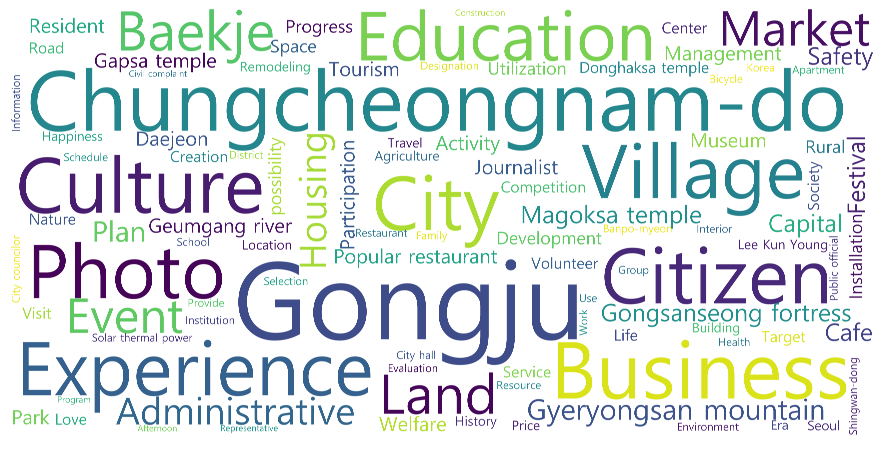

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.3,
                      background_color='white',
                      scale=64
                      ).generate_from_frequencies(todict(rank_list[:displayCnt]))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()